In [1]:
%load_ext autoreload
%autoreload 2
%load_ext rpy2.ipython
%config InlineBackend.figure_format = 'retina'

import rpy2
import csv
import logging
import random
from typing import List, Dict, Callable, Union, Tuple
import networkx as nx
import numpy as np
import pandas
import plotly
import plotly.graph_objects as go
import seaborn
from IPython.core.display import clear_output
from pandas import DataFrame, Series
from rpy2.robjects import numpy2ri
from rpy2.robjects.packages import importr
from scipy.stats import pearsonr
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from toolz import compose, partial, valmap

from deps.clustering import get_cluster_mapping_by_prevalence, GaussianMixtureProtocol, map_y_pred_by_prevalence, \
    sort_y_proba_by_prevalence
from deps.formatting import compare_metrics_in_table
from deps.formatting import format_feature_short
from hcve_lib.functional import statements, find_index, t
from deps.data import data_biomarkers_13_X, data_biomarkers_all_X, data_biomarkers, y_labels
from deps.data import data_biomarkers_all_y
from deps.network_analysis import make_graph, get_degree_values, get_weighted_degree, \
    make_graph_from_adjacency_matrix, get_adjacency_power_transform
from deps.metadata import get_biomarkers_metadata
from hcve_lib.visualisation import display_html
from deps.formatting import list_of_lists_to_html_table
from hcve_lib.functional import flatten
from deps.formatting import set_integer_ticks

from hcve_lib.functional import pipe
from deps.formatting import format_percents,  confusion_matrix_to_table,  h2, h3

from hcve_lib.evaluation_functions import get_1_class_y_score, get_confusion_from_threshold
from deps.evaluation_functions import ModelCVResult, compute_classification_metrics_from_results_with_statistics, \
    get_list_of_scores_from_repeated_cv_results,  average_list_of_confusion_matrices, join_repeats_and_folds_cv_results, get_cv_results_from_simple_cv_evaluation

from deps.visualisation import plot_roc_from_results_averaged

from deps.cache import load_data

from matplotlib import pyplot
from IPython.core.pylabtools import figsize
from hcve_lib.utils import random_seed


random_seed(21523)

rpy2.robjects.numpy2ri.activate()

figsize(10, 10)

PLOTLY_STYLE = 'plotly'
EXPORT_FORMAT = 'png'

OUTPUT_FOLDER = './output/'

TEST = False
OUTPUT = True

pandas.set_option('display.max_rows', 500)
plotly.io.orca.config.executable = './node_modules/.bin/orca'
seaborn.set()
wgcna = importr('WGCNA')

if OUTPUT:
    logging.getLogger().setLevel(logging.ERROR)


X_all = data_biomarkers_all_X
X = data_biomarkers_13_X
X_correlated_removed = data_biomarkers_13_X
X_biclustering = data_biomarkers_13_X
y_true = data_biomarkers_all_y['LVDDF']

def get_generated_correlated_dataset(correlation_matrix):
    n_features = len(correlation_matrix)
    mu = np.array(n_features*[0])
    r2 = correlation_matrix**2
    return DataFrame(np.random.multivariate_normal(mu, r2, size=500), columns=[chr(num+97) for num in range(n_features)])

def get_generated_y_true(n):
    return Series([statements(
        num := round(random.random()),
        num,
    ) for _ in range(n)], index=X.index)

bics_for_k_range = range(1, 15)

display_html(f'''
    <table>
        <tr><th>Dataset n=</th><td>{len(X)}</td></tr>
    </table>
''')

clear_output()



# Clustering analysis

## Biclustering heatmap

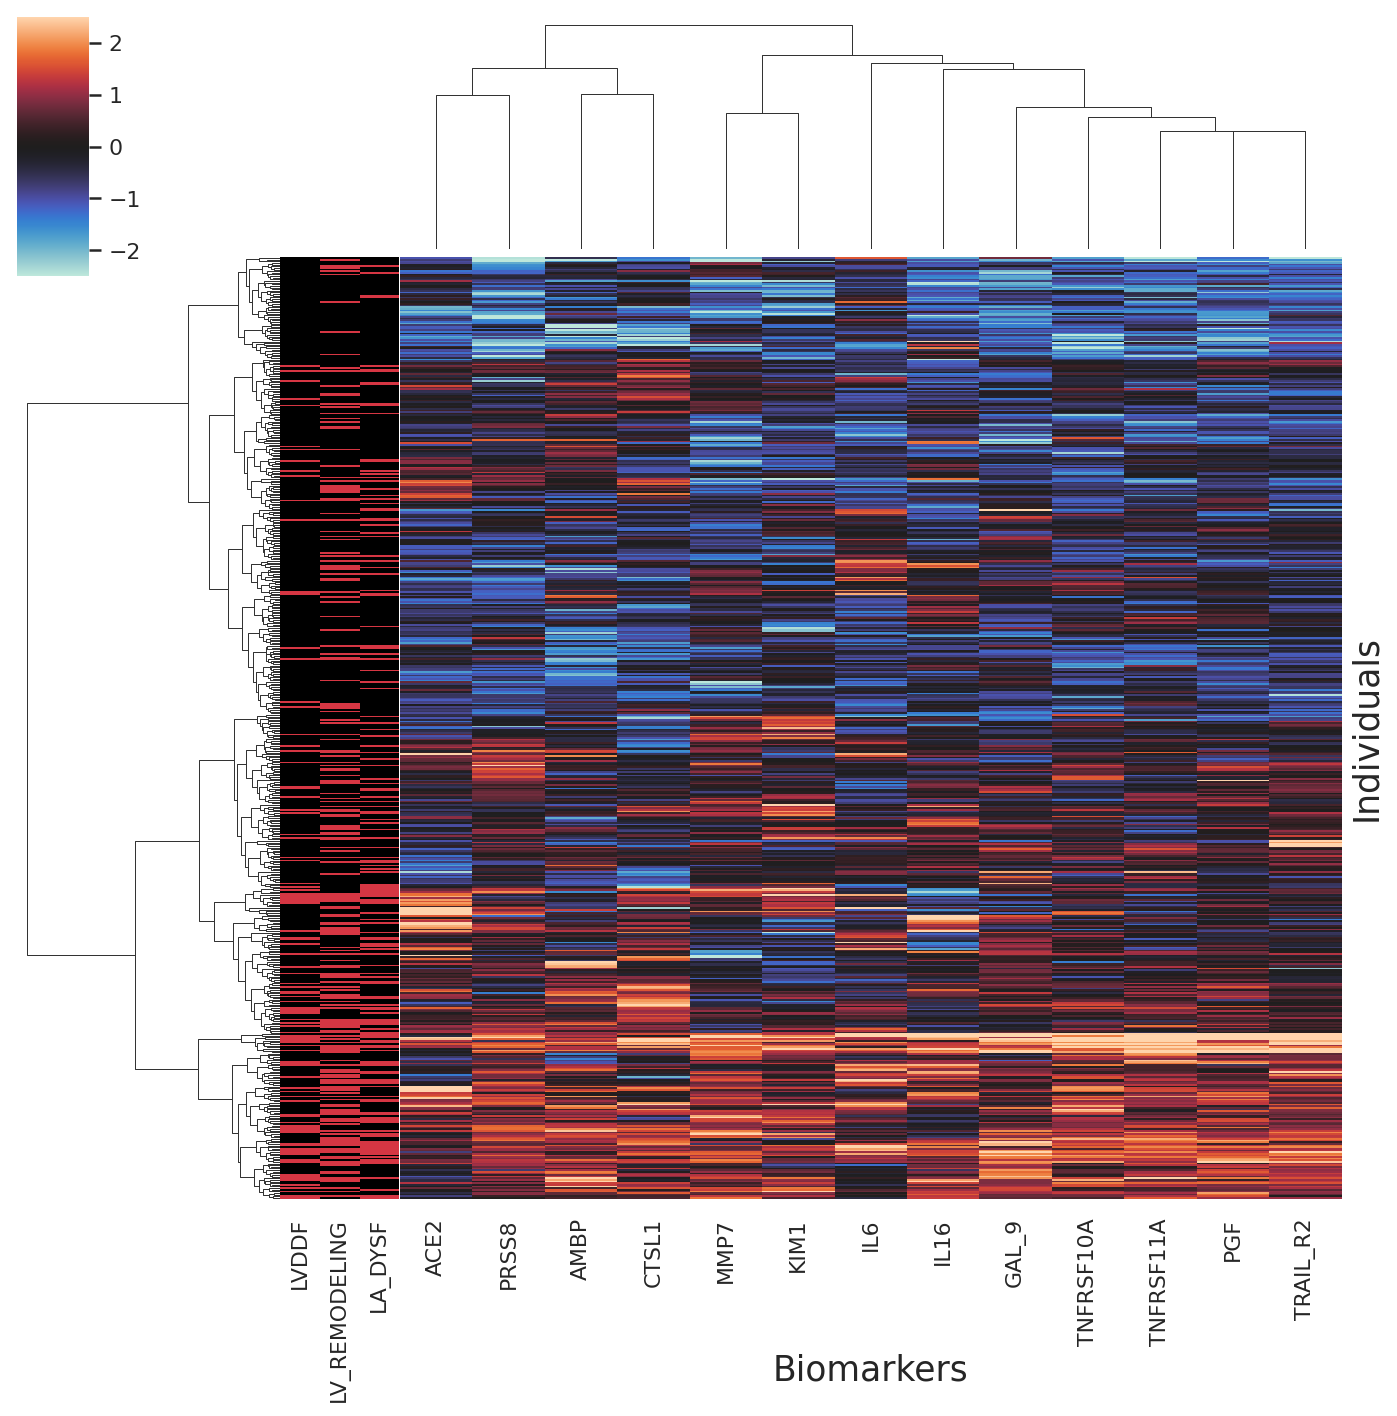

In [2]:
biclustering_heatmap = seaborn.clustermap(
    X,
    z_score=1,
    robust=True,
    method='ward',
    # metric="euclidean",
    center=0,
    vmin=-2.5,
    vmax=2.5,
    row_colors=DataFrame(
        {
            y_biclustering_name: ['#d63643' if label_for_row == 1 else 'black' for label_for_row in y_biclustering]
            for y_biclustering_name, y_biclustering in data_biomarkers_all_y.items()
        }
    ),
    # tree_kws={'color': 'white'},
)
biclustering_heatmap.ax_heatmap.set_xlabel('Biomarkers', fontsize='x-large')
biclustering_heatmap.ax_heatmap.set_ylabel('Individuals', fontsize='x-large')

c = '#FF0000'
biclustering_heatmap.ax_heatmap.set_yticks([])
pyplot.show()

## Selection of cluster number

In [3]:
bics_for_k_range = range(1,15)

k_selection_protocol = GaussianMixtureProtocol(parameters={'clustering__n_init': 50, 'clustering__covariance_type': 'full'})
bics_for_k = []
other_metrics_for_k = []
for k in bics_for_k_range:
    model = k_selection_protocol.get_pipeline_with_params(k)
    model.fit(X)
    y_pred = model.predict(X)
    other_metrics_for_k.append(k_selection_protocol.measure_internal_metrics(X, y_pred))
    bic_for_k = model[-1].bic(X.to_numpy())
    bics_for_k.append(bic_for_k)
    print('.', end='')
print()

..............


/tmp/ipykernel_1365264/2594644112.py:26: UserWarning:

This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.



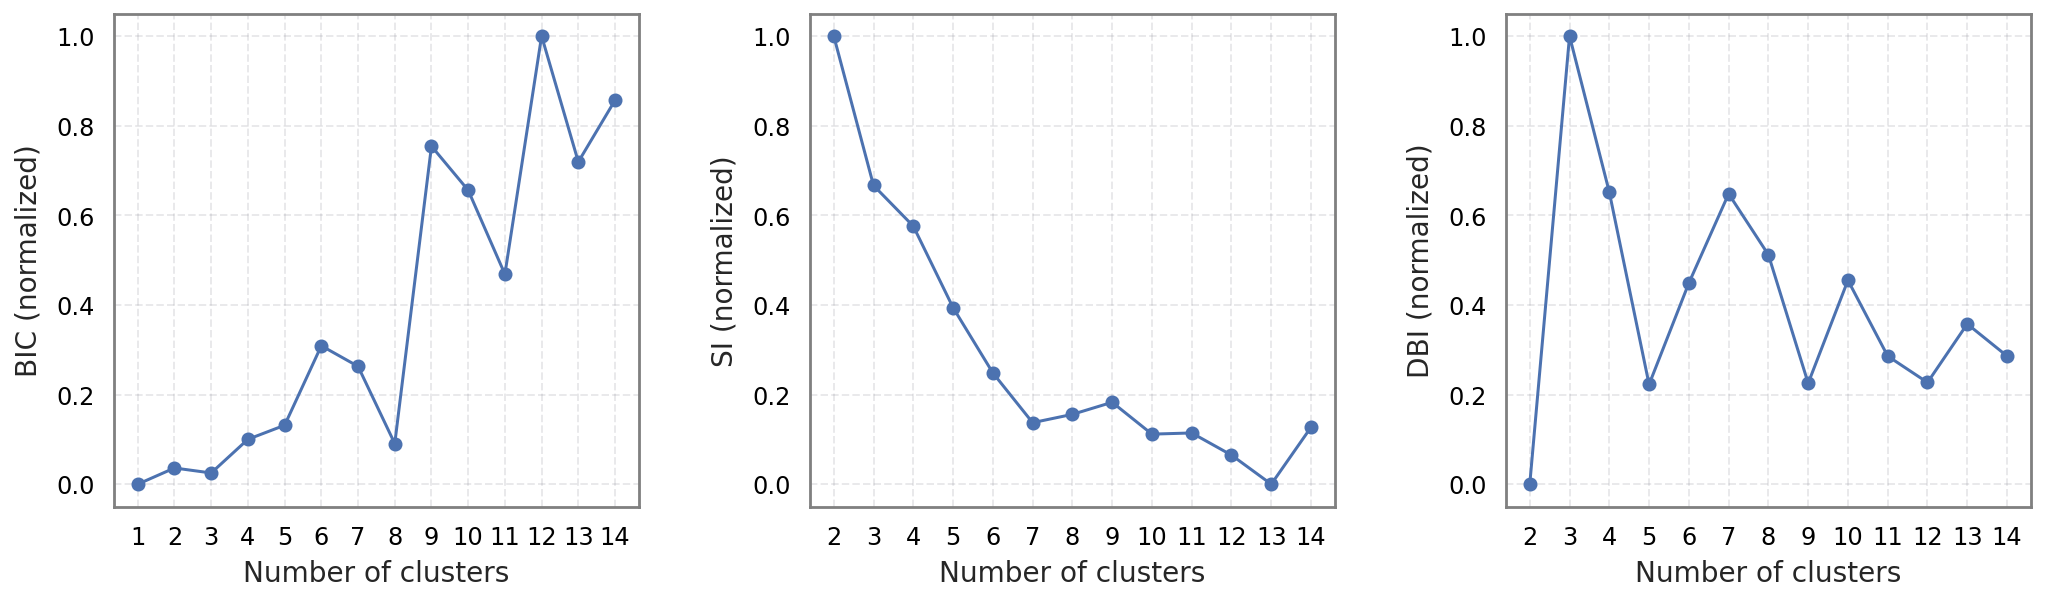

In [4]:
from deps.visualisation import plot_style

fig, ax = pyplot.subplots(1, 3, figsize=(15,5), constrained_layout=True)
ax = iter(ax)

other_metrics_for_k_df = DataFrame(other_metrics_for_k)
current_axis = next(ax)
y_bics_for_k = MinMaxScaler().fit_transform(DataFrame(bics_for_k))
plot_style(axis=current_axis)
current_axis.plot(bics_for_k_range, y_bics_for_k, zorder=2)
current_axis.set_xticks(bics_for_k_range)
current_axis.scatter(bics_for_k_range, y_bics_for_k, zorder=2)
current_axis.set_xlabel('Number of clusters')
current_axis.set_ylabel('BIC (normalized)')

for index, (metric_name, metric_values) in enumerate(other_metrics_for_k_df.items()):
    current_axis = next(ax)
    plot_style(axis=current_axis)
    metric_values_scaled = MinMaxScaler().fit_transform(DataFrame(metric_values))
    current_axis.plot(bics_for_k_range, metric_values_scaled, zorder=2)
    current_axis.set_xticks(bics_for_k_range)
    current_axis.scatter(bics_for_k_range, metric_values_scaled, zorder=2)
    current_axis.set_xlabel('Number of clusters')
    current_axis.set_ylabel(f'{metric_name.upper()} (normalized)')

fig.tight_layout(pad=3)
fig.show()

In [5]:
N_CLUSTERS=2

## Assignments

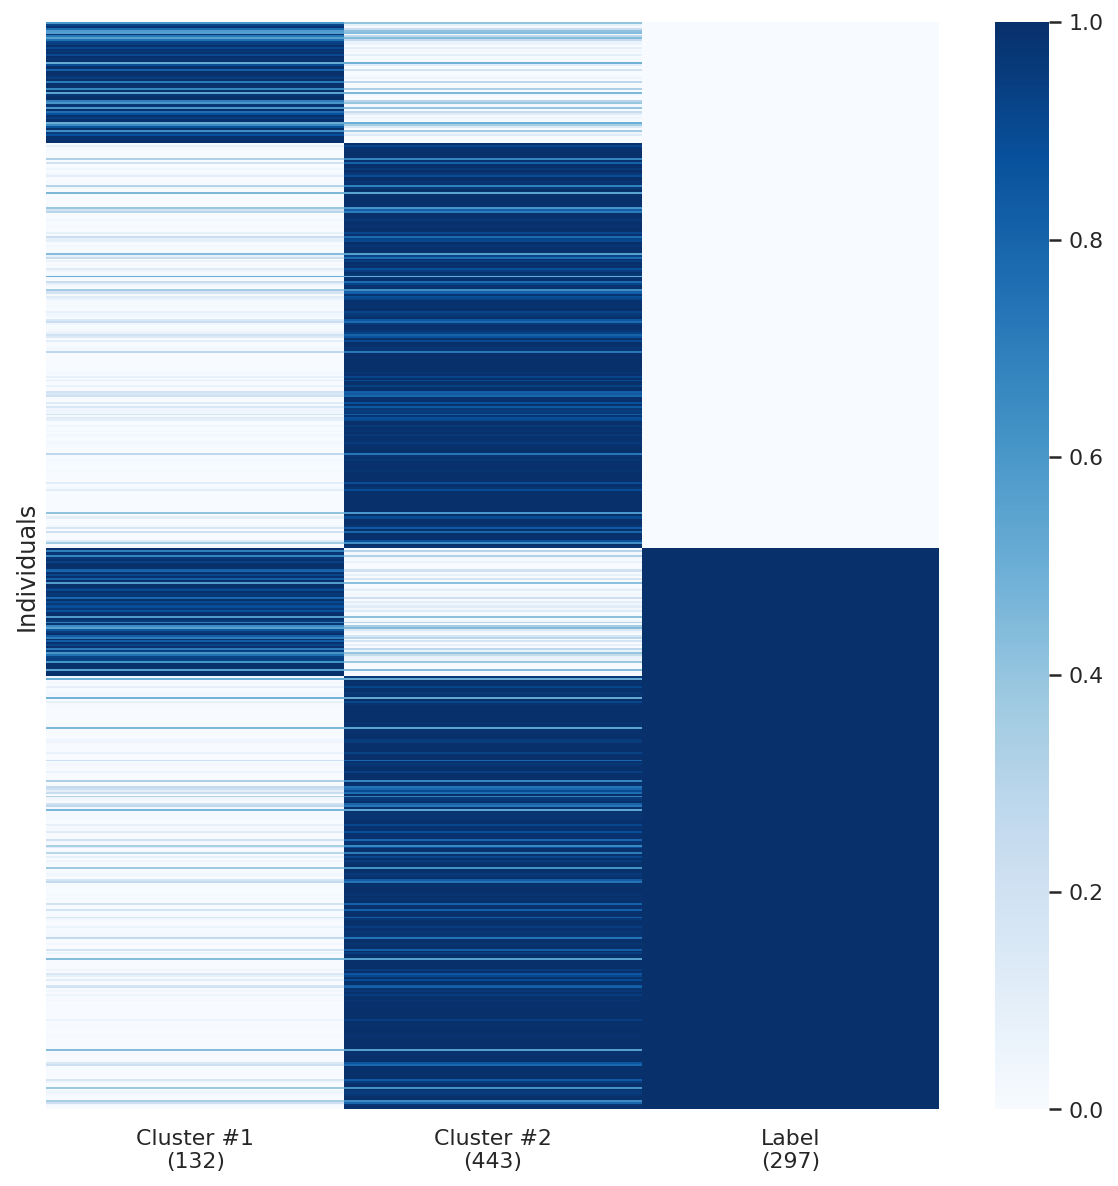

In [6]:
data_biomarkers_all_y_reduced = {'LVDDF': data_biomarkers_all_y['LVDDF']}

y_true = get_generated_y_true(len(X))

data_biomarkers_all_y_reduced = {'Label': y_true}

pipeline = GaussianMixtureProtocol(parameters={'clustering__covariance_type': 'full'}).get_pipeline_with_params(N_CLUSTERS)

pipeline.fit(X)

y_pred = Series(pipeline.predict(X), index=X.index)
y_pred = map_y_pred_by_prevalence(y_pred, y_true)

y_proba = DataFrame(pipeline.predict_proba(X), index=X.index)
y_proba = sort_y_proba_by_prevalence(y_proba, y_true)

y_proba_with_label = y_proba.copy().assign(
    y_pred=y_pred, **data_biomarkers_all_y_reduced
)
y_proba_with_label = y_proba_with_label.sort_values(by=[*data_biomarkers_all_y_reduced.keys(), 'y_pred'])

seaborn.set_style({'font.family': 'Arial'})
cluster_counts = y_pred.value_counts()

keys = sorted(cluster_counts.keys())
seaborn.heatmap(
    y_proba_with_label[[*keys, *(data_biomarkers_all_y_reduced.keys())]],
    cmap='Blues',
    xticklabels=[
        *[
            f'Cluster #{index+1}\n({cluster_counts[index]})'
            for index, key in enumerate(keys)
        ],
        *[
            statements(
                y_value_counts := y.value_counts(),
                f'{y_name}\n({y_value_counts[1]})'
            )
            for y_name, y in data_biomarkers_all_y_reduced.items()
        ],
    ]
)

pyplot.gca().axes.get_yaxis().set_ticks([])
pyplot.ylabel('Individuals')

y_proba_with_label \
    .assign(CPNBRX=data_biomarkers['CPNBRX']) \
    .to_csv('./output/probabilistic_assignment.csv', index=False)

pyplot.show()

# ASSERT
y_pred_test = [
    statements(
        max_value := max(row),
        find_index(lambda value: value == max_value, row)
    )
    for _, row in y_proba.iterrows()
]

assert y_pred_test == list(y_pred)


## Outcome prevalence per cluster

In [7]:
for y_name_for_prevalence, y_for_prevalence in data_biomarkers_all_y.items():
    prevalence_by_cluster = [['Cluster #', 'No outcome', 'Outcome', ' Total']]
    for cluster_index in range(N_CLUSTERS):
        prevalence_by_cluster_row = [cluster_index+1]
        counts_per_cluster = y_for_prevalence[y_pred==cluster_index].value_counts()
        cluster_sum = counts_per_cluster.sum()
        for y_pred_value, y_pred_value_count in counts_per_cluster.items():
            percentage = format_percents(y_pred_value_count/cluster_sum)
            prevalence_by_cluster_row.append(f'{y_pred_value_count} ({percentage})')
        prevalence_by_cluster_row.append(cluster_sum)
        prevalence_by_cluster.append(prevalence_by_cluster_row)
    h3(y_name_for_prevalence)
    display_html(list_of_lists_to_html_table(prevalence_by_cluster, style='font-size: 15px'))

In [8]:
for y_name_for_prevalence, y_for_prevalence in data_biomarkers_all_y.items():
    prevalence_by_cluster = [['Cluster #', 'No outcome', 'Outcome', ' Total']]
    for cluster_index in range(N_CLUSTERS):
        prevalence_by_cluster_row = [cluster_index+1]
        counts_per_cluster = y_for_prevalence[y_pred==cluster_index].value_counts()
        cluster_sum = counts_per_cluster.sum()
        for y_pred_value, y_pred_value_count in counts_per_cluster.items():
            percentage = format_percents(y_pred_value_count/cluster_sum)
            prevalence_by_cluster_row.append(f'{y_pred_value_count} ({percentage})')
        prevalence_by_cluster_row.append(cluster_sum)
        prevalence_by_cluster.append(prevalence_by_cluster_row)
    h3(y_name_for_prevalence)
    display_html(list_of_lists_to_html_table(prevalence_by_cluster, style='font-size: 15px'))


## Radar chart: Comparison between phenogroups showing z-score

In [9]:
X_ordered = X

scaler = StandardScaler()
scaler.fit(X)
clusters = get_cluster_mapping_by_prevalence(y_pred, y_true)
fig = go.Figure()
fig.update_layout(showlegend=True, width=900, height=650, template=PLOTLY_STYLE, font={'size': 18, 'color': 'black'}, margin={
    'l': 180,
    'r': 10,
    'b': 10,
    't': 10,
})

colors = ['olivedrab', 'orange', 'crimson']
label = ['low risk', 'medium risk', 'high risk']

for index, cluster in enumerate(clusters):
    fig.add_trace(go.Scatterpolar(
          r=scaler.transform(X[y_pred==cluster]).mean(axis=0),
          theta=list(map(compose(format_feature_short, lambda item: ("c" if TEST else "")+str(item)), X_ordered.columns)),
          name=f'Cluster #{index+1}',
          line = {'color': colors[index], 'width': 4},
    ))

if OUTPUT:
    fig.show(renderer="notebook")
else:
    fig.show()

# Network analysis

## Checking outliers in protein levels

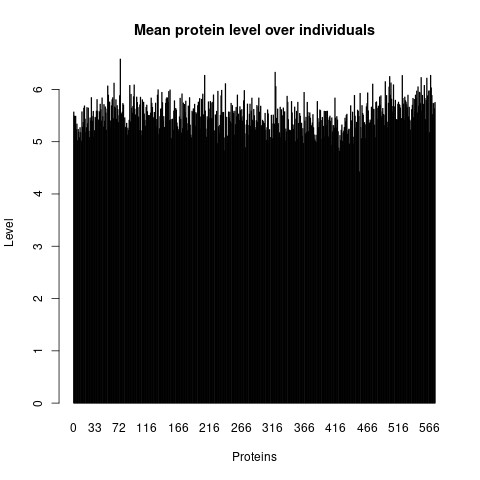

In [10]:
%%R -i data_biomarkers_all_X
library(WGCNA)
options(stringsAsFactors = FALSE);

X <- data.frame(data_biomarkers_all_X)
meanExpressionByArray=apply( X,1,mean, na.rm=T)
NumberMissingByArray=apply( is.na(data.frame(X)),1, sum)

barplot(meanExpressionByArray, xlab='Proteins', ylab='Level', main ="Mean protein level over individuals",)

## Scale free fitting index (Beta = 4)


Choosing beta, $R^2$ should be close to 1

 softConnectivity: FYI: connecitivty of genes with less than 192 valid samples will be returned as NA.
 ..calculating connectivities....0%..100% 
  scaleFreeRsquared slope
1              0.59 -0.71


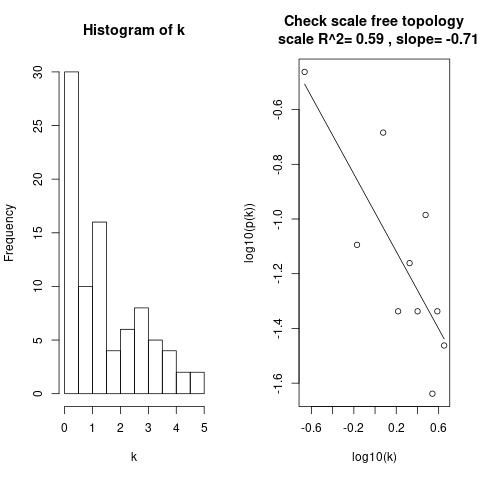

In [11]:
%%R -i X_all
k=softConnectivity(datE=X_all,power=4)
par(mfrow=c(1,2))
hist(k)
scaleFreePlot(k, main="Check scale free topology\n")

## Scale free fitting index (Beta = 5)

 softConnectivity: FYI: connecitivty of genes with less than 192 valid samples will be returned as NA.
 ..calculating connectivities....0%..100% 
  scaleFreeRsquared slope
1              0.91 -0.81


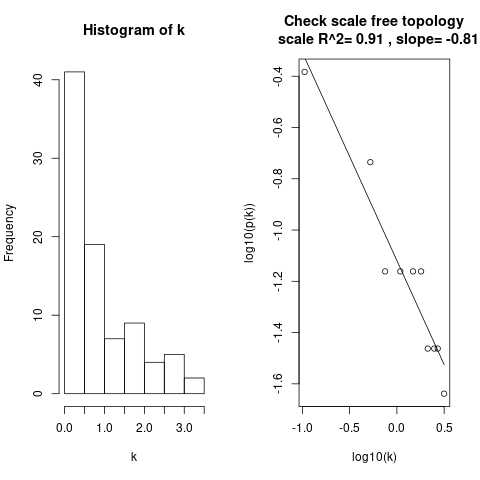

In [12]:
%%R -i X_all
k=softConnectivity(datE=X_all,power=5)
par(mfrow=c(1,2))
hist(k)
scaleFreePlot(k, main="Check scale free topology\n")

## Graph

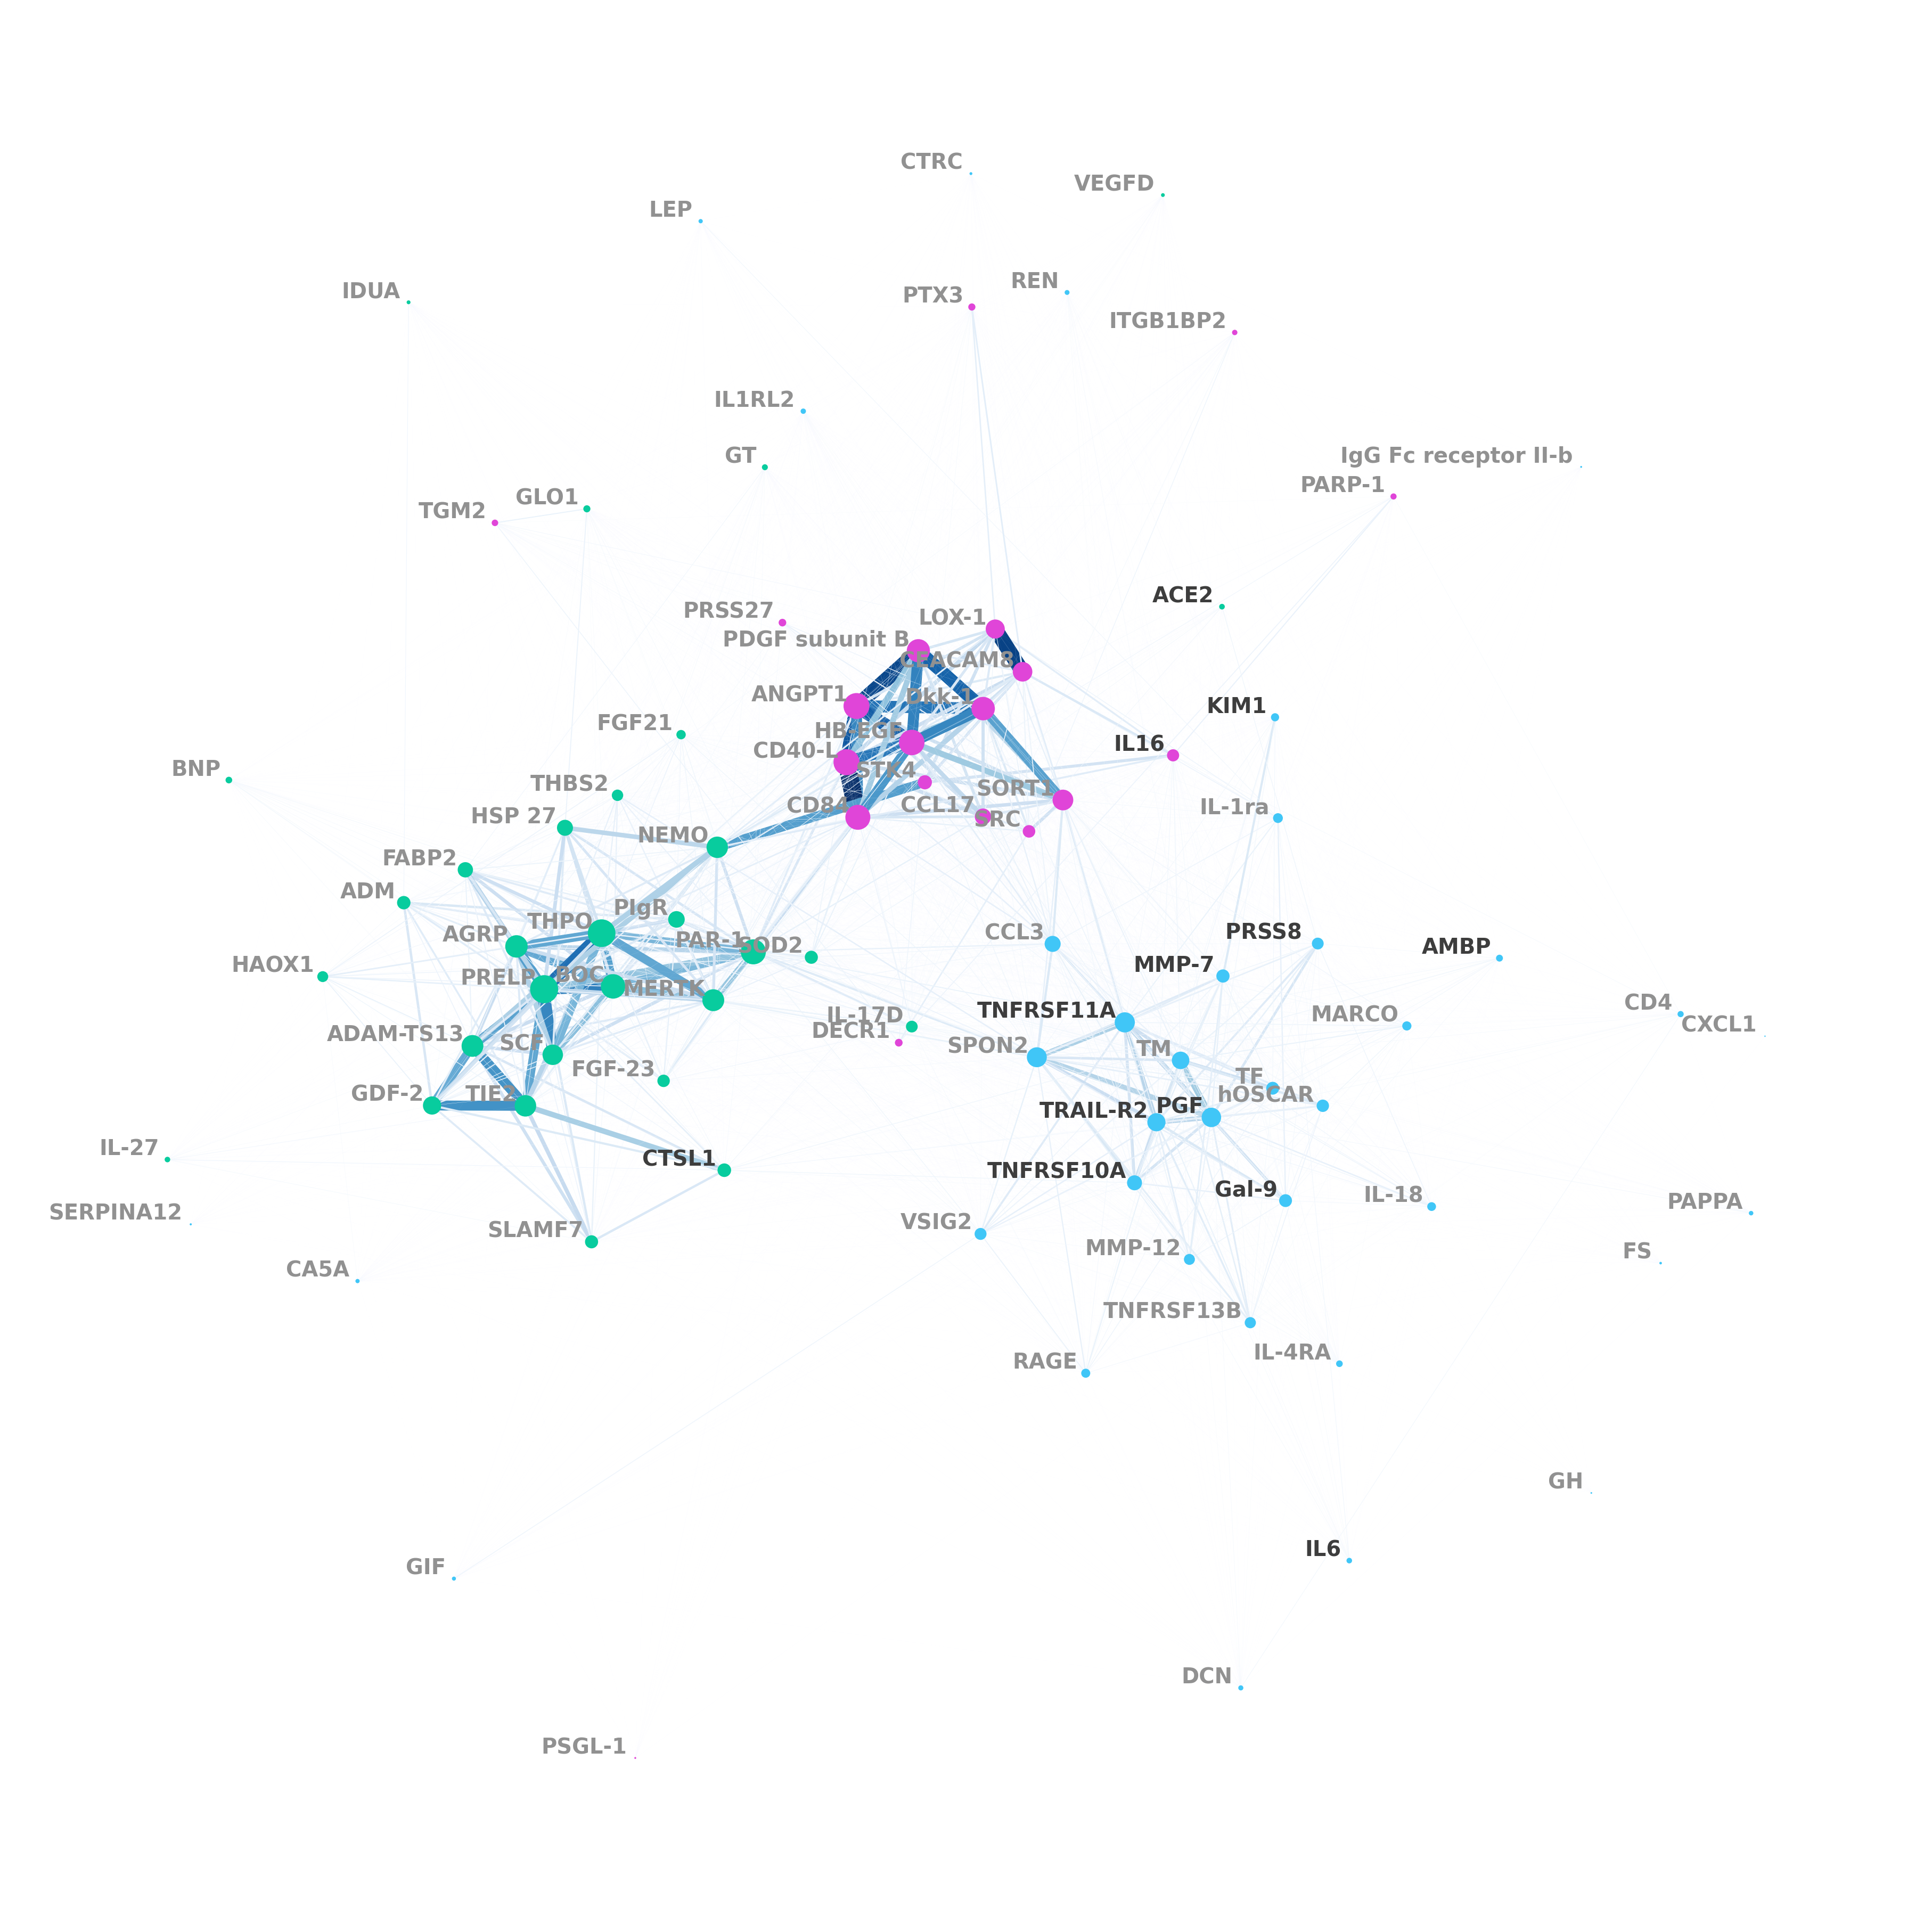

In [13]:
import networkx
from community import community_louvain
from matplotlib import pyplot
from networkx import Graph, degree, get_edge_attributes
from pandas import DataFrame
from toolz import identity

POWERS = range(5,6)

olink_feature_name_mapping = {key: item['feature_olink'] for key, item in get_biomarkers_metadata().items()}

def draw_graph(
        graph: Graph, position, edge_width_scale=1, node_width_scale=1, plot_parameters: Dict = None,
        box_background: Union[bool, str] = None, modules_colors: List[str] = None,
        transform_node_dataset: Callable[[Dict], Dict] = identity,
        min_node_size: float = 0, font_color: Union[str, Dict] = None,
        node_size=None, labels: Dict = None, render: Tuple = None
) -> None:
    plot_parameters = plot_parameters if plot_parameters is not None else {}
    edges, weights = zip(*get_edge_attributes(graph, 'weight').items())

    weight_for_edge_color = list(get_edge_attributes(graph, 'real_weight').values())

    if weight_for_edge_color == []:
        weight_for_edge_color = weights

    if node_size is None:
        node_size = dict(degree(graph, weight='weight'))

    if labels is None:
        labels = {}

    nodes = node_size.keys()
    partition = community_louvain.best_partition(graph, random_state=2315)
    colors = [modules_colors[partition[feature]] if modules_colors else partition[feature] for feature in nodes]

    node_size_transformed = transform_node_dataset(node_size)
    node_size_adjusted = {
        key: value * node_width_scale for key, value in node_size_transformed.items()
    }

    node_size_adjusted_list = [node_size_adjusted[key] for key in nodes]

    weight_for_edge_color = [value*2 for value in weight_for_edge_color]

    # noinspection PyUnresolvedReferences
    networkx.draw(
        graph,
        position,
        **{
            **dict(
                nodelist=nodes,
                edgelist=edges,
                edge_color=weight_for_edge_color,
                edge_cmap=pyplot.cm.Blues,
                edge_vmin=0,
                edge_vmax=1,
                node_color=colors,
                width=[weight * edge_width_scale for weight in weights],
                with_labels=False,
                node_size=node_size_adjusted_list,
            ),
            **plot_parameters,
        }
    )
    box_color = ('blue' if box_background is True else box_background) if box_background not in (None, False) else None

    for keys, color in font_color.items():
        applied_to_labels = {
            key: labels[key] if key in labels else key for key in keys
        }
        networkx.draw_networkx_labels(
            graph,
            labels=applied_to_labels,
            pos={key: (x - 0.01, y) for key, (x, y) in position.items()},
            font_size=20,
            font_weight='bold',
            font_color=color or 'white',
            bbox=dict(
                edgecolor=box_color,
                facecolor=box_color,
            ),
            horizontalalignment='right',
            verticalalignment='bottom',
        )

    x_values, y_values = zip(*position.values())
    x_max = max(x_values)
    x_min = min(x_values)
    x_margin = (x_max - x_min) * 0.1
    pyplot.xlim(x_min - x_margin, x_max + x_margin)



for power in POWERS:
    nodes = list(data_biomarkers_all_X.columns)
    adjacency_matrix = data_biomarkers_all_X.corr().pow(power)
    graph = make_graph_from_adjacency_matrix(DataFrame(adjacency_matrix, columns=nodes, index=nodes))
    graph_position = nx.spring_layout(graph, seed=5, k=0.25)
    edges, weights = zip(*nx.get_edge_attributes(graph, 'weight').items())
    degree_centrality = dict(nx.degree(graph, weight='weight'))
    nodes = degree_centrality.keys()
    h3(f'Power {power}')
    graph_figsize_arg = dict(figsize=(25, 25))
    pyplot.figure(**graph_figsize_arg)
    draw_graph(
        graph, graph_position, box_background='#00000000', node_width_scale=200, edge_width_scale=30,
        modules_colors=['#40c6f7', '#e045d8', '#08cc9e'], font_color={frozenset(X.columns): '#3d3d3d', frozenset(X_all.columns)-frozenset(X.columns): '#919191'},
        render = ('graph')
    )
    pyplot.savefig(f'{OUTPUT_FOLDER}/power_5_network.svg', dpi=400, bbox_inches='tight')
    partition = community_louvain.best_partition(graph, random_state=2315)
    pyplot.show()

In [14]:
partition = community_louvain.best_partition(graph, random_state=2315)
graph_position = nx.spring_layout(graph, seed=5, k=1, iterations=100)
edges,weights = zip(*nx.get_edge_attributes(graph,'weight').items())
degree_centrality = dict(nx.degree(graph, weight='weight'))
eigen_centrality = nx.eigenvector_centrality(graph, weight='weight')
betweenness_centrality = nx.betweenness_centrality(graph, weight='weight')
metadata = pipe(
    get_biomarkers_metadata(),
    partial(valmap, lambda item: {
        **item,
        'sumOfWeightsCentrality': degree_centrality[item['feature']] if item['feature'] in nodes else None,
        'eigenCentrality': eigen_centrality[item['feature']] if item['feature'] in nodes else None,
        'betweennessCentrality': betweenness_centrality[item['feature']] if item['feature'] in nodes else None,
        'categories': ", ".join(item['categories']),
        'partition': partition[item['feature']] if item['feature'] in nodes else None,
    })
)

nx.set_node_attributes(graph, metadata)

with open(f'{OUTPUT_FOLDER}/graph_all.gml', 'w') as f:
    f.writelines(nx.generate_gml(graph))

metadata_list = list(metadata.values())

with open(f'{OUTPUT_FOLDER}/biomarkers_network_analysis.csv', 'w') as f:  # Just use 'w' mode in 3.x
    w = csv.DictWriter(f, metadata_list[0].keys())
    w.writeheader()
    w.writerows(metadata_list)